# Lecture 4, Snowball Earth, the ice-albedo feedback, and multiple equilibria

Thanks a lot to [Henri Drake](https://github.com/hdrake) for providing the lecture.

The original lecture is part of the MIT class [Introduction to Computational Thinking](https://computationalthinking.mit.edu/Fall20/lecture20/).

This class uses the [Julia programming language](http://www.julialang.org/). The orignal code can be found under https://github.com/hdrake/simplEarth/blob/master/2_ebm_multiple_equilibria.jl

# Snowball Earth, the ice-albedo feedback, and multiple equilibria

![](https://static01.nyt.com/images/2019/12/17/science/02TB-SNOWBALLEARTH1/02TB-SNOWBALLEARTH1-superJumbo-v2.jpg?quality=90&auto=webp)
[Source (New York Times)](https://static01.nyt.com/images/2019/12/17/science/02TB-SNOWBALLEARTH1/02TB-SNOWBALLEARTH1-superJumbo-v2.jpg?quality=90&auto=webp)

## Review of Lecture 2

Recall from the last Lecture that the zero-dimensional energy balance equation is

\begin{gather}
\color{brown}{C \frac{dT}{dt}}
\; \color{black}{=} \; \color{orange}{\frac{(1 - α)S}{4}}
\; \color{black}{-} \; \color{blue}{(A - BT)}
\; \color{black}{+} \; \color{grey}{a \ln \left( \frac{[\text{CO}₂]}{[\text{CO}₂]_{\text{PI}}} \right)},
\end{gather}

![](https://raw.githubusercontent.com/hdrake/hdrake.github.io/master/figures/planetary_energy_balance.png)

Today, we will ignore changes in CO$_2$, so that

$\ln \left( \frac{ [\text{CO}₂]_{\text{PI}} }{[\text{CO}₂]_{\text{PI}}} \right) = \ln(1) = 0$

and the model simplifies to

\begin{gather}
\color{brown}{C \frac{dT}{dt}}
\; \color{black}{=} \; \color{orange}{\frac{(1 - α)S}{4}}
\; \color{black}{-} \; \color{blue}{(A - BT)}.
\end{gather}


The dynamics of this **Ordinary Differential Equation (ODE)** are quite simple because it is *linear*: we can rewrite it in the form

$$\dot{T} = f(T(t))$$

where 

$$f(x) = \alpha x + \beta$$

is a *linear* function of x. A linear ODE permits only one stable solution, $\dot{T} = 0$, which in Lecture 1 we found was Earth's pre-industrial temperature $T_{0} = 14$°C. 

In this lecture, we show how a small modification that makes one term in our simple climate model non-linear completely changes its dynamics, allowing us to explain the existence of both "Snowball Earth" and the relatively warm pre-industrial climate that allowed humans to thrive.

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from IPython.display import HTML
from IPython.display import display

## 1) Background: Snowball Earth
Geological evidence shows that the Neoproterozoic Era (550 to 1000 million years ago) is marked by two global glaciation events, in which Earth's surface was covered in ice and snow from the Equator to the poles (see review by [Pierrehumbert et al. 2011](https://www.annualreviews.org/doi/full/10.1146/annurev-earth-040809-152447).

![](https://news.cnrs.fr/sites/default/files/styles/asset_image_full/public/assets/images/frise_earths_glaciations_72dpi.jpg?itok=MgKrHlIV)

### 1.1) The ice-albedo feedback

In Lecture 1, we used a **constant** value $α = 0.3$ for Earth's planetary albedo, which is a reasonable thing to do for small climate variations relative to the present (such as the difference between the present-day and preindustrial climates). In the case of large variations, however, this approximation is not very reliable.

While oceans are dark and absorbant, $α_{ocean} \approx 0.05$, ice and snow are bright and reflective: $\alpha_{ice,\,snow} \approx 0.5$ to $0.9$. Thus, if much of the ocean's surface freezes over, we expect Earth's albedo to rise dramatically, causing more sunlight to be reflected to space, which in turn causes even more cooling and more of the ocean to freeze, etc. This *non-linear positive feedback effect* is referred to as the **ice-albedo feedback** (see illustration below).



![](https://upload.wikimedia.org/wikipedia/commons/d/df/Ice_albedo_feedback.jpg)

We can represent the ice-albedo feedback crudely in our energy balance model by allowing the albedo to depend on temperature:

$$\alpha(T) = \begin{cases}
\alpha_{i} & \mbox{if }\;\; T \leq -10\text{°C} &\text{(completely frozen)}\\
\alpha_{i} + (\alpha_{0}-\alpha_{i})\frac{T + 10}{20} & \mbox{if }\;\; -10\text{°C} \leq T \leq 10\text{°C} &\text{(partially frozen)}\\
\alpha_{0} &\mbox{if }\;\; T \geq 10\text{°C} &\text{(no ice)}
\end{cases}$$

### 1.2) Adding the ice-albedo feedback to our simple climate model
First, we program albedo as a function of temperature.

In [2]:
def calc_alpha(T, alpha0, alphai = 0.5, deltaT=10.):
    if T < - deltaT:
        return alphai
    elif -deltaT <= T < deltaT:
        return alphai + (alpha0 - alphai)*(T + deltaT) / (2*deltaT)
    elif T >= deltaT:         
        return alpha0

Text(13, 0.252, 'no ice')

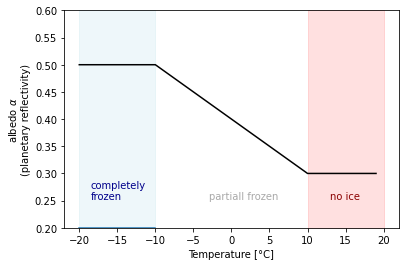

In [3]:
calc_alpha_vec = np.vectorize(calc_alpha) # boolean evaluations need to be vectorized
T_example = np.arange(-20, 20)
plt.plot(T_example, calc_alpha_vec(T_example[:], 0.3), color = "black")
plt.ylim(0.2,0.6)
plt.plot([-20, -10], [0.2, 0.2])
plt.fill_between([-20, -10], y1=0.2, y2=0.6, color = "lightblue", alpha = 0.2)
plt.fill_between([10, 20], y1=0.2, y2=0.6, color = "red", alpha = 0.12)
plt.ylabel("albedo $α$\n(planetary reflectivity)")
plt.xlabel("Temperature [°C]")
plt.text(-18.5, 0.252, s="completely\nfrozen", size=10, color="darkblue")
plt.text(-3, 0.252, s="partiall frozen", size=10, color="darkgrey")
plt.text(13, 0.252, s="no ice", size=10, color="darkred")

To add this function into our energy balance model from Lecture 1 (which we've copied into the cell below), all we have to do is overwrite the definition of the timestep! method to specify that the temperature-dependent albedo should be updated based on the current state:

In [4]:
class ebm():
    """
    Zero order energy balance model
    """

    def __init__(self, T, t, deltat, CO2):
        self.T = np.array(T)
        self.t = t
        
        self.deltat = deltat
        self.C = 51.
        self.a = 5.
        self.B = -1.3
        self.co2_pi = 280.
        self.alpha = 0.3
        self.S = 1368.
        self.co2 = CO2
        self.CO2_PI = 280.
        self.A = 221.2

    def absorbed_solar_radiation(self):
        return (self.S*(1-self.alpha2)/4.)  # [W/m^2]
    def outgoing_thermal_radiation(self):
        if self.T.size == 1:
            return self.A - self.B*self.T
        else:
            return self.A - self.B*self.T[-1]
    def greenhouse_effect(self):
        if self.T.size == 1:
            return self.a*np.log(self.co2(self.t)/self.CO2_PI)
        else:
            return self.a*np.log(self.co2(self.t[-1])/self.CO2_PI)
        
    def tendency(self):
        if self.T.size == 1:
             return 1. / self.C * (
            + self.absorbed_solar_radiation()
            - self.outgoing_thermal_radiation()
            + self.greenhouse_effect()
            )
        else:
            return 1. / self.C * (
            + self.absorbed_solar_radiation()
            - self.outgoing_thermal_radiation()
            + self.greenhouse_effect()
            )        
        
    def run(self, end_year):
        for year in range(end_year):
            self.timestep()
     
    def timestep(self):
        if self.T.size == 1:
            self.alpha2 = calc_alpha(self.T, alpha0=self.alpha) # Added the function call here
            self.T = np.append(self.T, self.T + self.deltat * self.tendency())
            self.t = np.append(self.t, self.t + self.deltat)
        else:
            self.alpha2 = calc_alpha(self.T[-1], alpha0=self.alpha) # Added the function call here
            self.T = np.append(self.T, self.T[-1] + self.deltat * self.tendency())
            self.t = np.append(self.t, self.t[-1] + self.deltat)


## 2) Multiple Equilibria
OR: the existence of "alternate Earths"

Human civilization flourished over the last several thousand years in part because Earth's global climate has been remarkably stable and forgiving. The preindustrial combination of natural greenhouse effect and incoming solar radiation yielded temperatures between the freezing and boiling points of water across most of the planet, allowing ecoystems based on liquid water to thrive.

The climate system, however, is rife with non-linear effects like the ice-albedo effect, which reveal just how fragile our habitable planet is and just how unique our stable pre-industrial climate was.

We learned in the last lecture that in response to temperature fluctuations, net-negative feedbacks act to restore Earth's temperature back towards a single equilibrium state in which absorbed solar radiation is balanced by outgoing thermal radiation. Here, we explore how non-linear positive feedbacks can temporarily result in a net-positive feedback and modify Earth's state space.

In [5]:
def CO2_const(t): # define CO2 scenario
    return 280

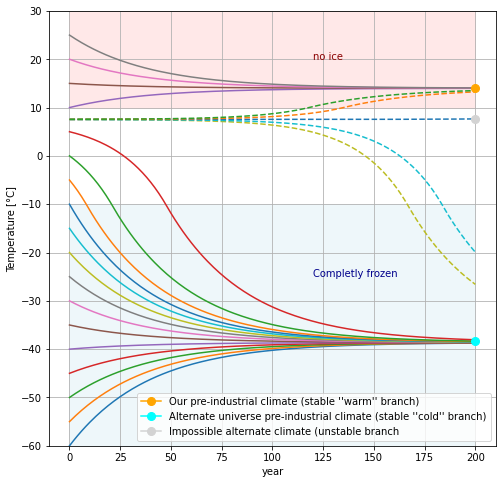

In [6]:
f, (ax) = plt.subplots(1, figsize = (8,8))

for count, T0_sample in enumerate(range(-60, 30, 5)):
    EBM = ebm(T0_sample, 0, 1., CO2_const)
    EBM.run(200)
    ax.plot(EBM.t, EBM.T)

ax.set_xlabel("year")
ax.set_ylabel("Temperature [°C]")
ax.set_ylim(-60,30)
ax.text(120,-25, s="Completly frozen", size = 10, color = "darkblue")
ax.fill_between([0, 200], y1=-60, y2=-10, color = "lightblue", alpha = 0.2)
ax.fill_between([0, 200], y1=10, y2=30, alpha=0.09, color="red")
ax.text(120,20, s="no ice", size = 10, color = "darkred")

T_un = 7.5472
deltaTs = 1e-2*np.array([-2, -1., 0., 1., 2.])
for deltaT in deltaTs:
    ebm_un = ebm(T_un+deltaT, 0., 1, CO2_const)
    ebm_un.run(200)
    ax.plot(ebm_un.t, ebm_un.T, ls = "--")
    
ax.grid()

ax.plot(200, 14, marker="o", label="Our pre-industrial climate (stable ''warm'' branch)", color="orange", markersize=8)
ax.plot(200, -38.3, marker="o", label="Alternate universe pre-industrial climate (stable ''cold'' branch)", color="aqua", markersize=8)
ax.plot(200, T_un, marker="o", label="Impossible alternate climate (unstable branch", color="lightgrey", markersize=8)
ax.legend(loc=4)

We see that for T₀ ⪆ 7.55 °C, all of the curves seem to converge on the T = 14°C equilibrium (or fixed point) that we saw in Lecture 20. Curves that start below this value warm up and while curves that start above this value will cool down. For T₀ ⪅ 7.55 °C, however, the temperatures converge on a much colder equilibrium around T = -40°C. This is the Snowball Earth equilibrium. These two states are referred to as stable equilibria because even if the state gets temporarily pushed slightly away from its equilibrium, it will eventually converge right back to its equilibrium.

So what happens is T₀ ≈ 7.55 °C? For some exact temperature near there, there is indeed an equilibrim state: if you start with that temperature you will stay there forever. However, if the temperature starts off even one one-hundredth of a degree above or below this exact value, we see that temperatures eventually converge to one of the other two equilibria. Thus, we call this intermediate equilibrium an unstable equilibrium, because any infinitesimal push away will cause it to careen away towards another state.

### Excourse:

* Nonlinear dynamics: stability and bifurcations

https://github.com/mitmath/18S191/blob/master/lecture_notebooks/week11/nonlinear_dynamics_bifurcations.jl

### 2.2) Radiative stability analysis
We can understand why our model has two stable equilibria and one unstable equilibrium by applying concepts from dynamical systems theory.

Recall that, with fixed CO₂ concentrations, our energy balance model differential equation can be expressed as:

$$C\frac{dT}{dT} = ASR(T) - OTR(T)$$

where now the Absorbed Solar Radiatio (ASR) is also temperature dependent because the albedeo $\alpha (T)$ is.

In particular, by plotting the right-hand-side tendency terms as a function of the state variable $T$, we can plot a stability diagram for our system that tells us whether the plan will warm ($C\frac{dT}{dt}$ > 0) or cool ($C\frac{dT}{dt}$ < 0)


In [7]:
EBM = ebm(T_un, 0., 1, CO2_const)
temp_range = np.arange(-60, 30)

OTR, ASR = np.zeros((len(temp_range))), np.zeros((len(temp_range)))

for count, i in enumerate(temp_range):
    EBM.T = np.array(i)
    EBM.alpha2 = calc_alpha(EBM.T, EBM.alpha)
    
    OTR[count] = EBM.outgoing_thermal_radiation()
    ASR[count] = EBM.absorbed_solar_radiation()
    
imbalance = ASR - OTR

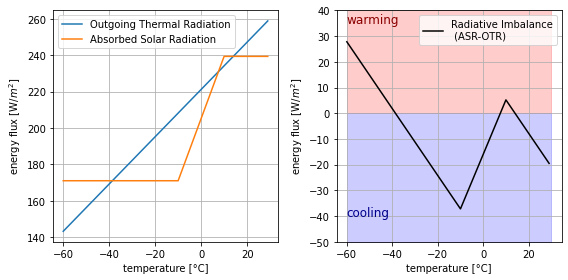

In [8]:
f, (ax, bx) = plt.subplots(1,2, figsize=(8,4))
ax.plot(temp_range, OTR, label= "Outgoing Thermal Radiation")
ax.plot(temp_range, ASR, label = "Absorbed Solar Radiation")
ax.set_xlabel("temperature [°C]")
ax.set_ylabel("energy flux [W/$m^2$]")

bx.fill_between([-60, 30], y1=0, y2=40, alpha=0.2, color="red")
bx.fill_between([-60, 30], y1=-50, y2=0, alpha=0.2, color="blue")
bx.set_xlabel("temperature [°C]")
bx.set_ylabel("energy flux [W/$m^2$]")
bx.set_ylim(-50,40)

bx.plot(temp_range, imbalance, color = "black", label = "Radiative Imbalance\n (ASR-OTR)")
bx.text(-60, 35, "warming", color ="darkred", size = 12)
bx.text(-60, -40, "cooling", color ="darkblue", size = 12)

ax.legend(); bx.legend()
ax.grid(); bx.grid()
f.tight_layout()

## 3) Transitioning to and from Snowball Earth
### 3.1) Turning up the Sun

Over the entire history of the Earth, the Sun is thought to have brightened by about 40%.

![](https://rainbow.ldeo.columbia.edu/courses/s4021/ec98/fys.gif)

In the Neoproterozoic (~700 million years ago), the Sun was 93% as bright as it is today, such that the incoming solar radiation was $S$ = 1272 W/m², Earth's average temperature plunged to $T = -50$°C, and Earth's ice-covered surface had a high albedo (reflectivity) of $\alpha_i = 0.5$.

### 3.2) Did the increasing brightness of the Sun melt the Snowball?
If we start out in the Neoproterozoic climate and all we do is increase solar insolation to today's value of $ S = 1368 W/m^2$, can we warm the planet up to the pre-industrial temperature of T = 14°C?

In [9]:
smin = 1200
smax = 1800
smax_limited = 1650
svec = np.arange(smin, smax)
svec = np.append(svec, svec[::-1])
tvec = np.zeros(svec.size)

In [10]:
t_restart = -100
for i, S in enumerate(svec):
    EBM = ebm(t_restart, 0., 5., CO2_const);
    EBM.S = S
    EBM.run(400)
    t_restart = EBM.T[-1]
    tvec[i] = EBM.T[-1]

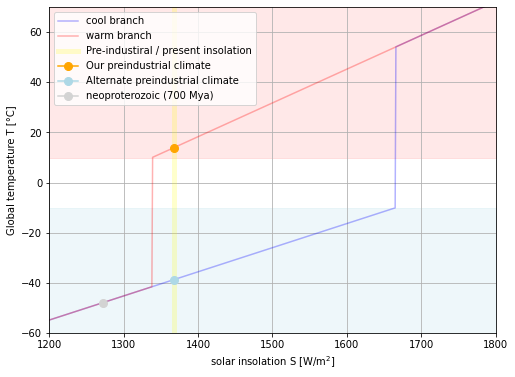

In [11]:
plt.figure(figsize = (8,6))
plt.plot(svec[0:len(svec)//2], tvec[0:len(svec)//2], color = "blue", label = "cool branch", alpha = 0.3)
plt.plot(svec[len(svec)//2:], tvec[len(svec)//2:], color = "red", label = "warm branch", alpha = 0.3)
plt.axvline(1368, color = "yellow", lw = 5, alpha = 0.2, label = "Pre-industiral / present insolation")

plt.plot(1368, tvec[svec==1368][1], marker="o", label="Our preindustrial climate", color="orange", markersize=8)
plt.plot(1368, tvec[svec==1368][0], marker="o", label="Alternate preindustrial climate", color="lightblue", markersize=8)
plt.plot(1368*0.93, -48, marker="o", label="neoproterozoic (700 Mya)", color="lightgrey", markersize=8)

plt.xlabel("solar insolation S [W/m$^2$]")
plt.ylabel("Global temperature T [°C]")

plt.fill_between([1200, 1800], y1=-60, y2=-10, color = "lightblue", alpha = 0.2)
plt.fill_between([1200, 1800], y1=10, y2=70, alpha=0.09, color="red")

plt.ylim(-60,70)
plt.xlim(1200,1800)

plt.legend()
plt.grid()

### Abrupt climate transitions

In this model, temperature variations are fairly smooth unless temperatures rise above -10°C or fall below 10°C, in which case the *ice-albedo positive feedback* kicks in and causes an **abrupt climate transition**. While this is just a simple hypothetical model, these kinds of abrupt climate transitions show up all the time in the paleoclimate record and in more realistic climate model simulations.
![](https://www.pnas.org/content/pnas/115/52/13288/F1.large.jpg)

This simulation teaches us that we should not take the stability of our climate for granted and that pushing our present climate outside of its historical regime of stability could trigger catastrophic abrupt climate transitions.


### 3.3) If not the Sun, how did Snowball Earth melt?

The leading theory is that a slow but steady outgassing of CO$_2$ from volcanoes eventually caused a strong enough greenhouse gas effect to offset the cooling effect of the frozen surface's high albedo and raise temperatures above the melting point $-10$°C.

![](https://hartm242.files.wordpress.com/2011/03/snowball-earth.jpg)

In Homework 1, you will extend the above model to include the effect of CO₂ and determine how much CO2 would need to be added to the snowball for it to melt.

### Towards realistic climate modelling
In this simple model, the preindustrial climate of °C is so warm that there is no ice anywhere on the planet. Indeed, the only two valid stable climates are one with no ice or one with ice everywhere.

So how did Earth's preindustrial climate, which was relatively stable for thousands of years, have substantial ice caps at the poles?

The "Aquaplanet", a simple three-dimensional ocean-world climate model

An "Aquaplanet" is a three-dimensional global climate simulation of a hypothetical planet covered entirely by a single global Ocean. While this is of course very different from Earth, where 27% of the planet is covered in land, the "Aquaplanet" exhibits many of the same characteristics as Earth and is much more realistic than our zero-dimensional climate model above.

The video below shows that the Aquaplanet simulation exhibits a third equilibrium state, with a mostly-liquid ocean but ice caps at the poles, in addition to the two we found in our zero-dimensional model.

In Homework 2, you will build a simple two-dimensional version of the aqua-planet and explore its stability.

[youtube](https://www.youtube-nocookie.com/embed/lYm_IyBHMUs)
